EDA - важный этап работы с данными. Именно в процессе EDA мы можем выяснить особенности датасета, найти зависимости в данных, протестировать гипотезы о взаимосвязях признаков и целевой переменной.

## О данных

Будем работать с [датасетом физической активности](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones).

В этом датасете собраны данные 30 человек, выполняющих различные действия со смартфоном на поясе. Данные записывались с помощью датчиков (акселерометра и гироскопа) в этом смартфоне. Были зафиксированы: "3-осевое линейное ускорение" (_tAcc-XYZ_) и "3-осевая угловая скорость" (_tGyro-XYZ_).

1. Все сигналы отсортированы по времени, пропущены через фильтр шума.
2. Все наблюдения были разделены на окна по 128 сигналов в каждом, причем окна пересекаются на 50% (грубо говоря, с 1 по 128 сигнал в 1 окно, с 64 до 192 сигнала - во 2 окно и так далее).
3. Линейное ускорение было разделено на две составляющие (с помощью низкочастотного фильтра): ускорение самого тела, а также гравитационная составляющая. Будем называть их ускорением тела и гравитационным ускорением.
4. К получившимся окнам применяли различные функции для получения следующих показателей:
    - max
    - min
    - mad (median)
    - mean
    - std
    - skewness (коэффициент асимметричности распределения признака в окне)
    - etc. (подробнее, на сколько это возможно, указано на [страничке датасета](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones))
5. Величина (magnitude) сигнала также определялась через евклидову норму всех значений из вектора для одного окна.
6. К окнам было применено преобразование Фурье, чтобы получить частоты. Из частот были извелченыте же показатели, плюс новые:
    - bandsEnergy (энергия частотного интервала)
7. Были посчитаны углы между векторами соответствующих окон.
8. Для ускорений были посчитаны производные - рывки, к которым применялись те же функции.

Итог: в датасете каждый признак - это какая-то операция над вектором из 128 чисел, которые соответствуют замерам определенного человека занятого какой-то активностью на протяжении 2.56 секунд.

Как читать названия признаков? Примеры:
- `tBodyAccMag-mean()` - это вектор ускорений тела (без гравитационной составляющей этого ускорения), из которого взяли евклидову норму, а затем усреднили, чтобы получить скаляр
- `fBodyAcc-bandsEnergy()-1,8.2` - это вектор ускорения тела, к которому применили преобразование Фурье, преобразовав его в вектор частот, а затем посчитали на этом векторе энергию данного частотного интервала в определенном диапазоне частот (в данном случае 1 - 8.2)
- `angle(X,gravityMean)` - это угол между осью Х и вектором усредненных значений гравитационного ускорения из соответствующего окна

## Предобработка данных

Activity Recognition Experiment Using Smartphone Sensors: https://www.youtube.com/watch?v=XOEN9W05_4A&ab_channel=JorgeLuisReyesOrtiz
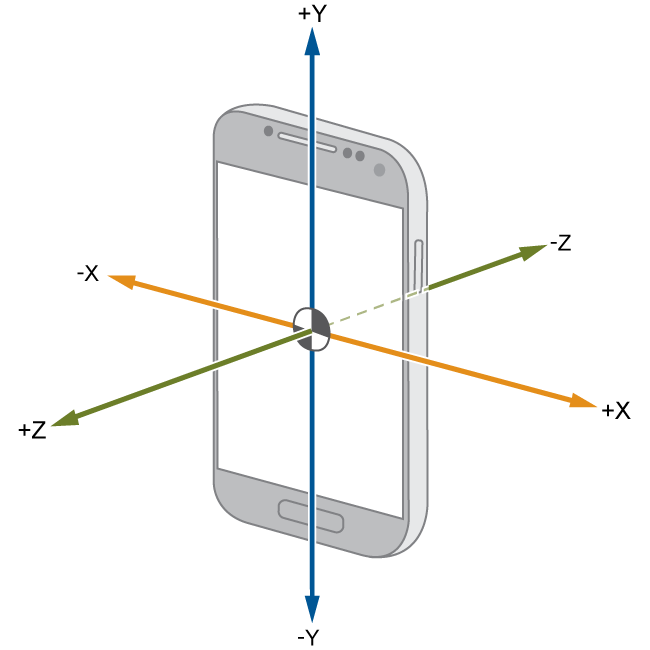

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!wget https://github.com/d-da-das-dash-dasha/hw_3/raw/main/archive.zip
!unzip /content/archive.zip

--2024-03-02 12:30:22--  https://github.com/d-da-das-dash-dasha/hw_3/raw/main/archive.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/d-da-das-dash-dasha/hw_3/main/archive.zip [following]
--2024-03-02 12:30:23--  https://raw.githubusercontent.com/d-da-das-dash-dasha/hw_3/main/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25693584 (25M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]  24.50M   157MB/s    in 0.2s    

2024-03-02 12:30:23 (157 MB/s) - ‘archive.zip’ saved [25693584/25693584]

Archive:  /content/archive.zip
  inflating: tes

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

In [ ]:
print(train.shape)
print(test.shape)

(7352, 563)
(2947, 563)


В датасете 563 признака, включая целевую переменную. Столько признаков нам не нужно. Сделаем подвыборку признаков для удобства работы с ними.

In [ ]:
cols_subset = [
    'tBodyAccMag-mean()',  # усредненная величина ускорения тела
    'tBodyGyroJerk-mad()-X',  # медианная величина рывка тела по оси Х
    'tGravityAcc-min()-X',  # минимум гравитационной составляющей ускорения по оси Х
    'tBodyAcc-max()-X',  # максимальная величина ускорения тела по оси Х
    'fBodyAcc-bandsEnergy()-1,8.2',  # энергия ускорения тела в интервале частоты
    'angle(X,gravityMean)',  # угол между осью Х и усредненной гравитационной составляющей ускорения
    'angle(Y,gravityMean)',  # угол между осью Y и усредненной гравитационной составляющей ускорения
    'angle(Z,gravityMean)',  # угол между осью Z и усредненной гравитационной составляющей ускорения,
    'fBodyAcc-skewness()-X',  # асимметричность частоты ускорения тела по оси Х
    'subject',  # номер испытуемого
    'Activity',  # название вида деятельности (целевая переменная)
]

In [ ]:
train = train[cols_subset]
test = test[cols_subset]

In [ ]:
train

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject,Activity
0,-0.959434,-0.992165,0.977436,-0.934724,-0.993592,-0.841247,0.179941,-0.058627,0.142051,1,STANDING
1,-0.979289,-0.989876,0.984520,-0.943068,-0.998235,-0.844788,0.180289,-0.054317,-0.692541,1,STANDING
2,-0.983703,-0.987868,0.986770,-0.938692,-0.999388,-0.848933,0.180637,-0.049118,-0.727227,1,STANDING
3,-0.986542,-0.991241,0.986821,-0.938692,-0.999807,-0.848649,0.181935,-0.047663,-0.599118,1,STANDING
4,-0.992827,-0.992882,0.987434,-0.942469,-0.999806,-0.847865,0.185151,-0.043892,-0.676997,1,STANDING
...,...,...,...,...,...,...,...,...,...,...,...
7347,-0.031719,-0.533656,0.920554,0.210795,-0.274644,-0.791883,0.238604,0.049819,-0.154387,30,WALKING_UPSTAIRS
7348,-0.065256,-0.609540,0.920554,0.117440,-0.310596,-0.771840,0.252676,0.050053,-0.053694,30,WALKING_UPSTAIRS
7349,-0.003936,-0.662918,0.933008,0.043999,0.034897,-0.779133,0.249145,0.040811,0.363110,30,WALKING_UPSTAIRS
7350,-0.002445,-0.645452,0.933008,0.101702,0.040506,-0.785181,0.246432,0.025339,0.382837,30,WALKING_UPSTAIRS


### Пропуски и дубли

Посмотрим на пропуски и дубли в данных train и test.

In [ ]:
print(train.isnull().any().any())
print(test.isnull().any().any())

print(train.duplicated().any())
print(test.duplicated().any())

False
False
False
False


Пропусков и дублей нет.

### Статистики данных

Выведем основные статистики данных: среднее, медиана, перцентили (0.25, 0.5, 0.75), минимум, максимум, стандартное отклонение.

In [ ]:
print('Train:', train.describe(), sep='\n', end='\n\n\n')
print('Test:', test.describe(), sep='\n')

Train:
       tBodyAccMag-mean()  tBodyGyroJerk-mad()-X  tGravityAcc-min()-X  \
count         7352.000000            7352.000000          7352.000000   
mean            -0.543884              -0.727735             0.678505   
std              0.477653               0.315832             0.508656   
min             -1.000000              -0.999889            -1.000000   
25%             -0.983282              -0.991595             0.804270   
50%             -0.883371              -0.950268             0.926693   
75%             -0.106892              -0.474625             0.965095   
max              1.000000               1.000000             1.000000   

       tBodyAcc-max()-X  fBodyAcc-bandsEnergy()-1,8.2  angle(X,gravityMean)  \
count       7352.000000                   7352.000000           7352.000000   
mean          -0.468604                     -0.847963             -0.489547   
std            0.544547                      0.233633              0.511807   
min           -1.00

1. **Согласованность между тренировочными и тестовыми данными**: cредние значения и стандартные отклонения по большинству характеристик схожи между тренировочными и тестовыми наборами, что говорит о хорошей согласованности данных и потенциальной способности обученной модели хорошо работать на тестовых данных.
2. **Минимальные и максимальные значения** для многих характеристик (примерно) равны -1 и 1 соответственно, что может свидетельствовать о нормализации данных перед их анализом.
3. **Стандартное отклонение** показывают довольно большой разброс по многим характеристикам. Я называю разброс большим, если стандартное отклонение составляет значительную долю от среднего значения (>= 0.5). Это указывает на разнообразие движений и позиций участников эксперимента.
4. **Ангулярные признаки**: углы (angle(X,gravityMean), angle(Y,gravityMean), angle(Z,gravityMean)) имеют разные диапазоны значений и стандартные отклонения, что связано с различными ориентациями тела во время выполнения упражнений.
5. **Асимметрия ускорения тела по оси X (fBodyAcc-skewness()-X)** чуть меньше 0, что указывает на незначительную левостороннюю асимметрию.
6. **Количество строк** в test почти в 2.5 раза меньше кол-ва строк в train, что говорит о том, что данные были распределены в соотношении примерно 70/30. Это оптимальный подход, потому что так модель сможет обучиться на достаточно большом наборе train, и при этом тестовая выборка с большей вероятностью будет репрезентативной (в сравнении с маленькой тестовой выборкой).



### Данные сбалансированы?

У нас есть 6 категорий активности (целевая переменная). Если одна из категорий представлена большим количеством наблюдений, а остальные - нет, то это обстоятельство, о котором хотелось бы знать заранее. Гиперболизированный пример: представим, что у нас 1000 наблюдений, разделенных на два класса, и только 5 принадлежат ко второму классу. Как учить модель на такой выборке? Есть сильное подозрение, что многие модели будут склонны вырождаться в константу. Отсюда и необходимость проверять баланс классов.

Выведем количество наблюдений для всех категорий активности в train и test. Посчитаем разницу в процентах между самой крупной категорией и самой маленькой (самая большая категория - это 100%). Если разница (округленная до ближайшего целого числа) не превышает 30%, то будем для наших целей считать, что данные сбалансированы.

In [ ]:
activity_counts_train = train['Activity'].value_counts()
print('Train:', activity_counts_train, sep='\n')
print('Difference between the largest and the smallest category: ',
      round((activity_counts_train.max() - activity_counts_train.min()) /
      activity_counts_train.max() * 100), '%', sep='')

activity_counts_test = test['Activity'].value_counts()
print('\n\nTest:', activity_counts_test, sep='\n')
print('Difference between the largest and the smallest category: ',
      round((activity_counts_test.max() - activity_counts_test.min()) /
      activity_counts_test.max() * 100), '%', sep='')



Train:
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64
Difference between the largest and the smallest category: 30%


Test:
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: Activity, dtype: int64
Difference between the largest and the smallest category: 22%


Разница между самой крупной (LAYING) и самой маленькой (WALKING_DOWNSTAIRS) категорией не превышает 30% в train и test, значит данные сбалансированы.

### Корреляции признаков

Посчитаем корреляции всех признаков (включая таргет) со всеми другими.

In [ ]:
activities = train['Activity'].unique()
train_with_ohe = train

for activity in activities:
  train_with_ohe[activity] = (train_with_ohe['Activity'] == activity).astype(int)

train_with_ohe = train_with_ohe.drop('Activity', axis=1)
train_with_ohe.corr()

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject,STANDING,SITTING,LAYING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
tBodyAccMag-mean(),1.000000,0.899080,0.369962,0.959827,0.697832,-0.370849,0.495561,0.426283,0.379796,-0.073652,-0.414460,-0.396389,-0.396643,0.358825,0.561344,0.405434
tBodyGyroJerk-mad()-X,0.899080,1.000000,0.380118,0.879900,0.507939,-0.382246,0.478567,0.380967,0.266002,-0.110321,-0.370699,-0.379403,-0.386730,0.531695,0.445048,0.257524
tGravityAcc-min()-X,0.369962,0.380118,1.000000,0.380404,0.239088,-0.988663,0.797116,0.667415,-0.261676,-0.042371,0.262354,0.187055,-0.973167,0.234820,0.192409,0.159741
tBodyAcc-max()-X,0.959827,0.879900,0.380404,1.000000,0.613383,-0.384192,0.480229,0.405023,0.335708,-0.055633,-0.399861,-0.387297,-0.394745,0.298526,0.658369,0.347429
"fBodyAcc-bandsEnergy()-1,8.2",0.697832,0.507939,0.239088,0.613383,1.000000,-0.213318,0.363170,0.423927,0.260316,-0.037000,-0.296141,-0.276766,-0.287395,0.189834,0.217399,0.534750
"angle(X,gravityMean)",-0.370849,-0.382246,-0.988663,-0.384192,-0.213318,1.000000,-0.783848,-0.643655,0.265523,0.026137,-0.266279,-0.181082,0.956927,-0.233903,-0.222029,-0.116118
"angle(Y,gravityMean)",0.495561,0.478567,0.797116,0.480229,0.363170,-0.783848,1.000000,0.594885,-0.046213,-0.009829,0.241314,-0.096667,-0.816776,0.243434,0.186124,0.310982
"angle(Z,gravityMean)",0.426283,0.380967,0.667415,0.405023,0.423927,-0.643655,0.594885,1.000000,-0.183815,-0.098712,0.167701,-0.065389,-0.678385,0.198901,0.162849,0.273889
fBodyAcc-skewness()-X,0.379796,0.266002,-0.261676,0.335708,0.260316,0.265523,-0.046213,-0.183815,1.000000,0.019742,-0.419856,-0.223813,0.206542,0.024511,0.176759,0.277785
subject,-0.073652,-0.110321,-0.042371,-0.055633,-0.037000,0.026137,-0.009829,-0.098712,0.019742,1.000000,0.018212,0.029473,0.028078,-0.047385,-0.014201,-0.019371


Корреляционная матрица показывает, как каждый признак связан с другими. Значения корреляции варьируются от -1 до 1, где:
*   Значение 1 показывает полную положительную линейную корреляцию;
*   Значение -1 показывает полную отрицательную линейную корреляцию;
*   Значение 0 показывает отсутствие линейной корреляции.

Линейная корреляция показывает, насколько точно можно предсказать величину одной переменной, зная значение другой.

1. **Высокая корреляция между исходными признаками**:  
*   tBodyAccMag-mean() и tBodyAcc-max()-X показывают великую положительную корреляцию (0.959827). Это так, потому что эти признаки измеряют величину ускорения тела и содержат перекрывающуюся информацию.
*   tGravityAcc-min()-X и angle(X,gravityMean) показывают высокую отрицательную корреляцию (-0.988663). Это так, потому что эти признаки содержат перекрывающуюся информацию: уменьшение минимального значения гравитационного ускорения по оси Х (tGravityAcc-min()-X) указывает на то, что устройство (т.е. часть тела) находилось в положении, более горизонтальном по отношению к земле, что также могло привести к увеличению угла между осью Х и вектором гравитации (angle(X,gravityMean)), поскольку направление гравитации становится более перпендикулярным к оси Х.
*  tGravityAcc-min()-X и LAYING показывают высокую отрицательную корреляцию (-0.973167). Значит, уменьшение tGravityAcc-min()-X указывает на то, что человек переходит в положение лежа. Из этого мы можем сделать вывод, что ось X на устройстве направлена перпендикулярно земле.
2. Корреляция между бинарными признаками, полученными с помощью OHE, и числовыми признаками не является особо информативной, за исключением наблюдения с LAYING в предыдущем пункте.







Мы предобработали данные для максимально комфортного их последующего анализа. Теперь мы готовы приступить к Exploratory Data Analysis!

## Exploratory Data Analysis

### Математические функции

Мы проверили основную информацию о данных и составили свое первое впечатление о них. Теперь визуализации.

Начнем рисовать графики с небольшой разминки. Выберем две математические функции и нарисуем их на одном графике. Подпишем каждый из графиков.

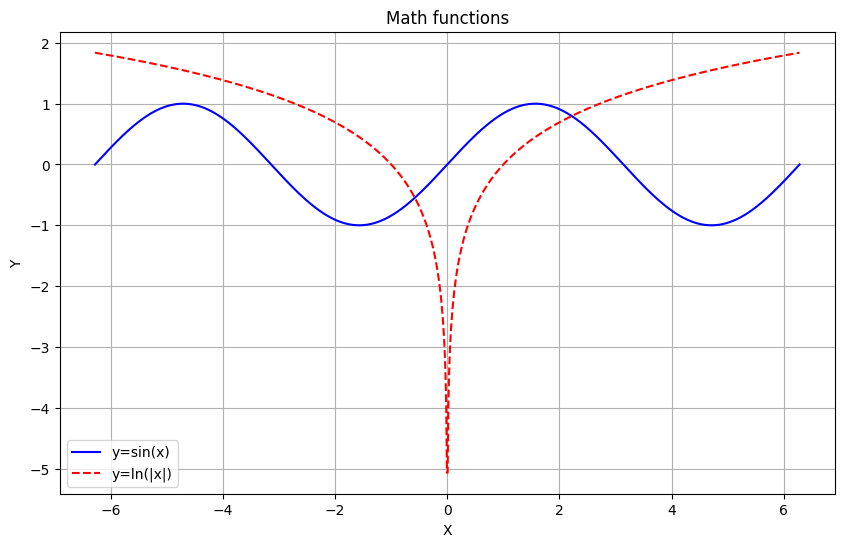

In [ ]:
# Cоздадим массив x, который будет содержать 1000 чисел,
# равномерно распределенных в диапазоне от −2π−2π до 2π2π.
x = np.linspace(-2*np.pi, 2*np.pi, 1000)

# Вычислим значения для каждой функции. На примере массива y_sin: каждая ячейка
# хранит значение функции sin для соответствующего элемента массива x
y_sin = np.sin(x)
y_ln = np.log(np.abs(x))

plt.figure(figsize=(10, 6))
# figure() создает новую фигуру (окно или плоскость для графика).
# Это как холст, на котором будут отображаться все дальнейшие рисунки.

# Построим график y = sin(x)
plt.plot(x, y_sin, label='y=sin(x)', color='blue')

# Построим графика y = ln(|x|)
plt.plot(x, y_ln, label='y=ln(|x|)', color='red', linestyle='dashed')

# Добавим заголовок
plt.title('Math functions')
# Функция plt.title устанавливает заголовок для активного
# (под)графика в текущем контексте рисования.

# Добавим легенду
plt.legend()

# Добавим метки для осей
plt.xlabel('X')
plt.ylabel('Y')

# Отобразим сетку
plt.grid(True)

# Выведем график
plt.show()

### Визуализация количества сэмплов

Ранее мы уже проверили сбалансированность данных по разным категориям активностей в train и test сетах. Теперь визуализируем количество сэмплов в каждой из категорий отдельно для train и test сетов. Проследим, чтобы порядок категорий слева и справа был одинаков. Иначе не очень удобно их сравнивать (когда они в разных местах двух графиков).

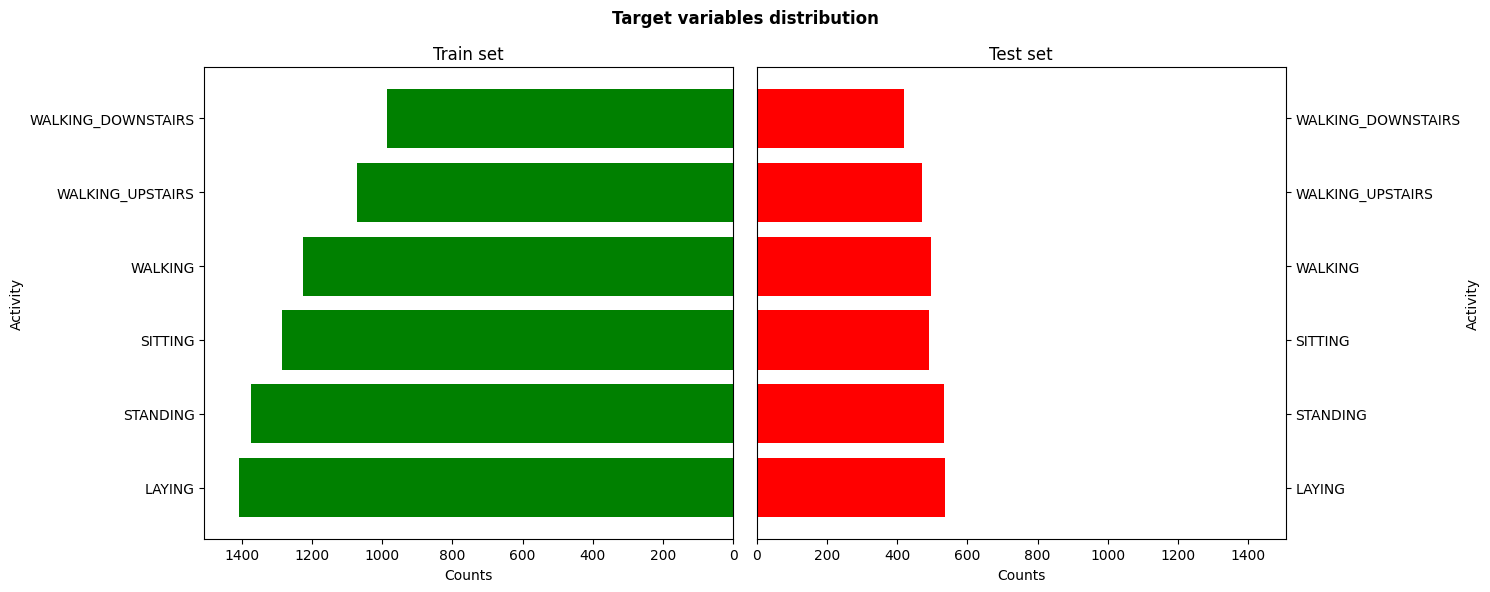

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# fig ссылается на объект всей фигуры,
# а ax1 и ax2 являются объектами подграфиков на этой фигуре

ax1.barh(activity_counts_train.index, activity_counts_train.values, color='green')
# barh -- это метод объекта axes (подграфика), который создает горизонтальную
# столбчатую диаграмму. Первый аргумент указывает метки по оси Y, второй -- по X.

# Добавим заголовок
ax1.set_title('Train set')

# Установим границы по оси X для ax1 в порядке убывания, чтобы отразить диаграмму
ax1.set_xlim([max(activity_counts_train.max(), activity_counts_test.max()) + 100, 0])
# Здесь можно было сразу взять activity_counts_train.max(), потому что мы ранее
# проанализировали эти данные. Но я решила написать код для общего случая.


# Создадим подграфик ax2 так, чтобы порядок категорий совпадал с порядком категорий ax1
ax2.barh(activity_counts_train.index, activity_counts_test[activity_counts_train.index], color='red')
ax2.set_title('Test set')

# Установим границы по оси X для ax2 так, чтобы они по величине совпадали
# с границами для графика ax1, но шли в возрастающем порядке
ax2.set_xlim([0, max(activity_counts_train.max(), activity_counts_test.max()) + 100])

# Переместим категории вправо
ax2.yaxis.tick_right()

# Добавим названия осей
for ax in (ax1, ax2):
    ax.set_xlabel('Counts')
    ax.set_ylabel('Activity')

# Переместим метку 'Activity' вправо
ax2.yaxis.set_label_position("right")

# Добавим общий заголовок
plt.suptitle('Target variables distribution', fontweight='bold')
# plt.suptitle устанавливает общий заголовок для всей фигуры

plt.tight_layout() # Сделает все красивым

plt.show()

На таких графиках проще проверять баланс классов таргета.

### heqtmap корреляций

Ранее мы выводили таблицу корреляций. Однако просто таблица корреляций не очень удобна для анализа. Что, если признаков было бы больше? Визуализируем heatmap корреляций. Подпишем значения корреляций, округленные до 2 знаков после запятой, на графике и оставим только те значения, которые по модулю не меньше 0.5. Будем считать такие корреляции существенными.

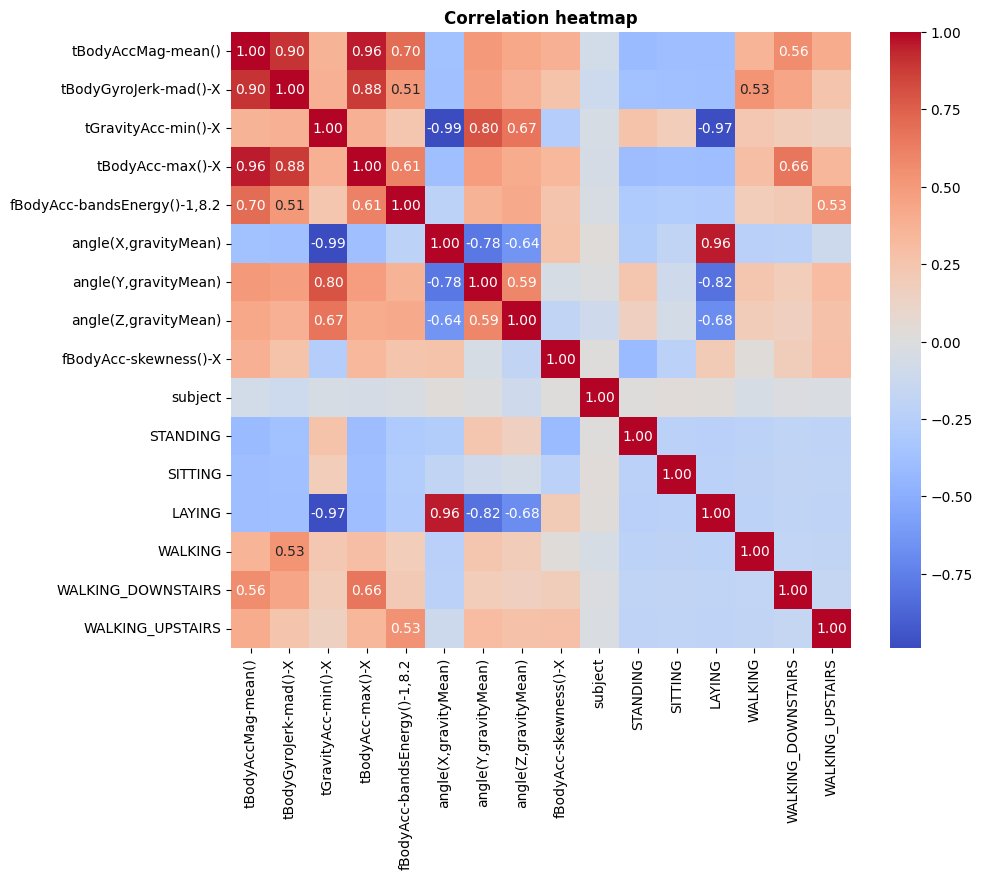

In [ ]:
correlation_matrix = train_with_ohe.corr()

# filtered_coor = correlation_matrix.where(abs(correlation_matrix) >= 0.5)
# Нам это не совсем подходит, потому что так у None будет один цвет,
# а мы хотим их ранжировать с помощью разных цветов

plt.figure(figsize=(10, 8))
annotation = correlation_matrix.applymap(lambda x: f'{x:.2f}' if abs(x) >= 0.5 else '')
sns.heatmap(correlation_matrix, annot=annotation, fmt='', cmap='coolwarm')
plt.title('Correlation heatmap', fontweight='bold')

plt.show()

Из рассмотрения стоит исключить признак subject, потому что это всего лишь порядковый номер испытыуемого, который, очевидно, не должен коррелировать с другими признаками.

Как я и писала выше, корреляция числовых признаков с категориальными признаками зачастую не дает никакой информации для выводов. Исключение здесь -- высокая корреляция между некоторыми признаками и LAYING, что помогает определить, куда направлены оси устройства.

### pairplot

Для начала будем стрелять из пушки по воробьям. Выведем pairplot по всем данным train сета.

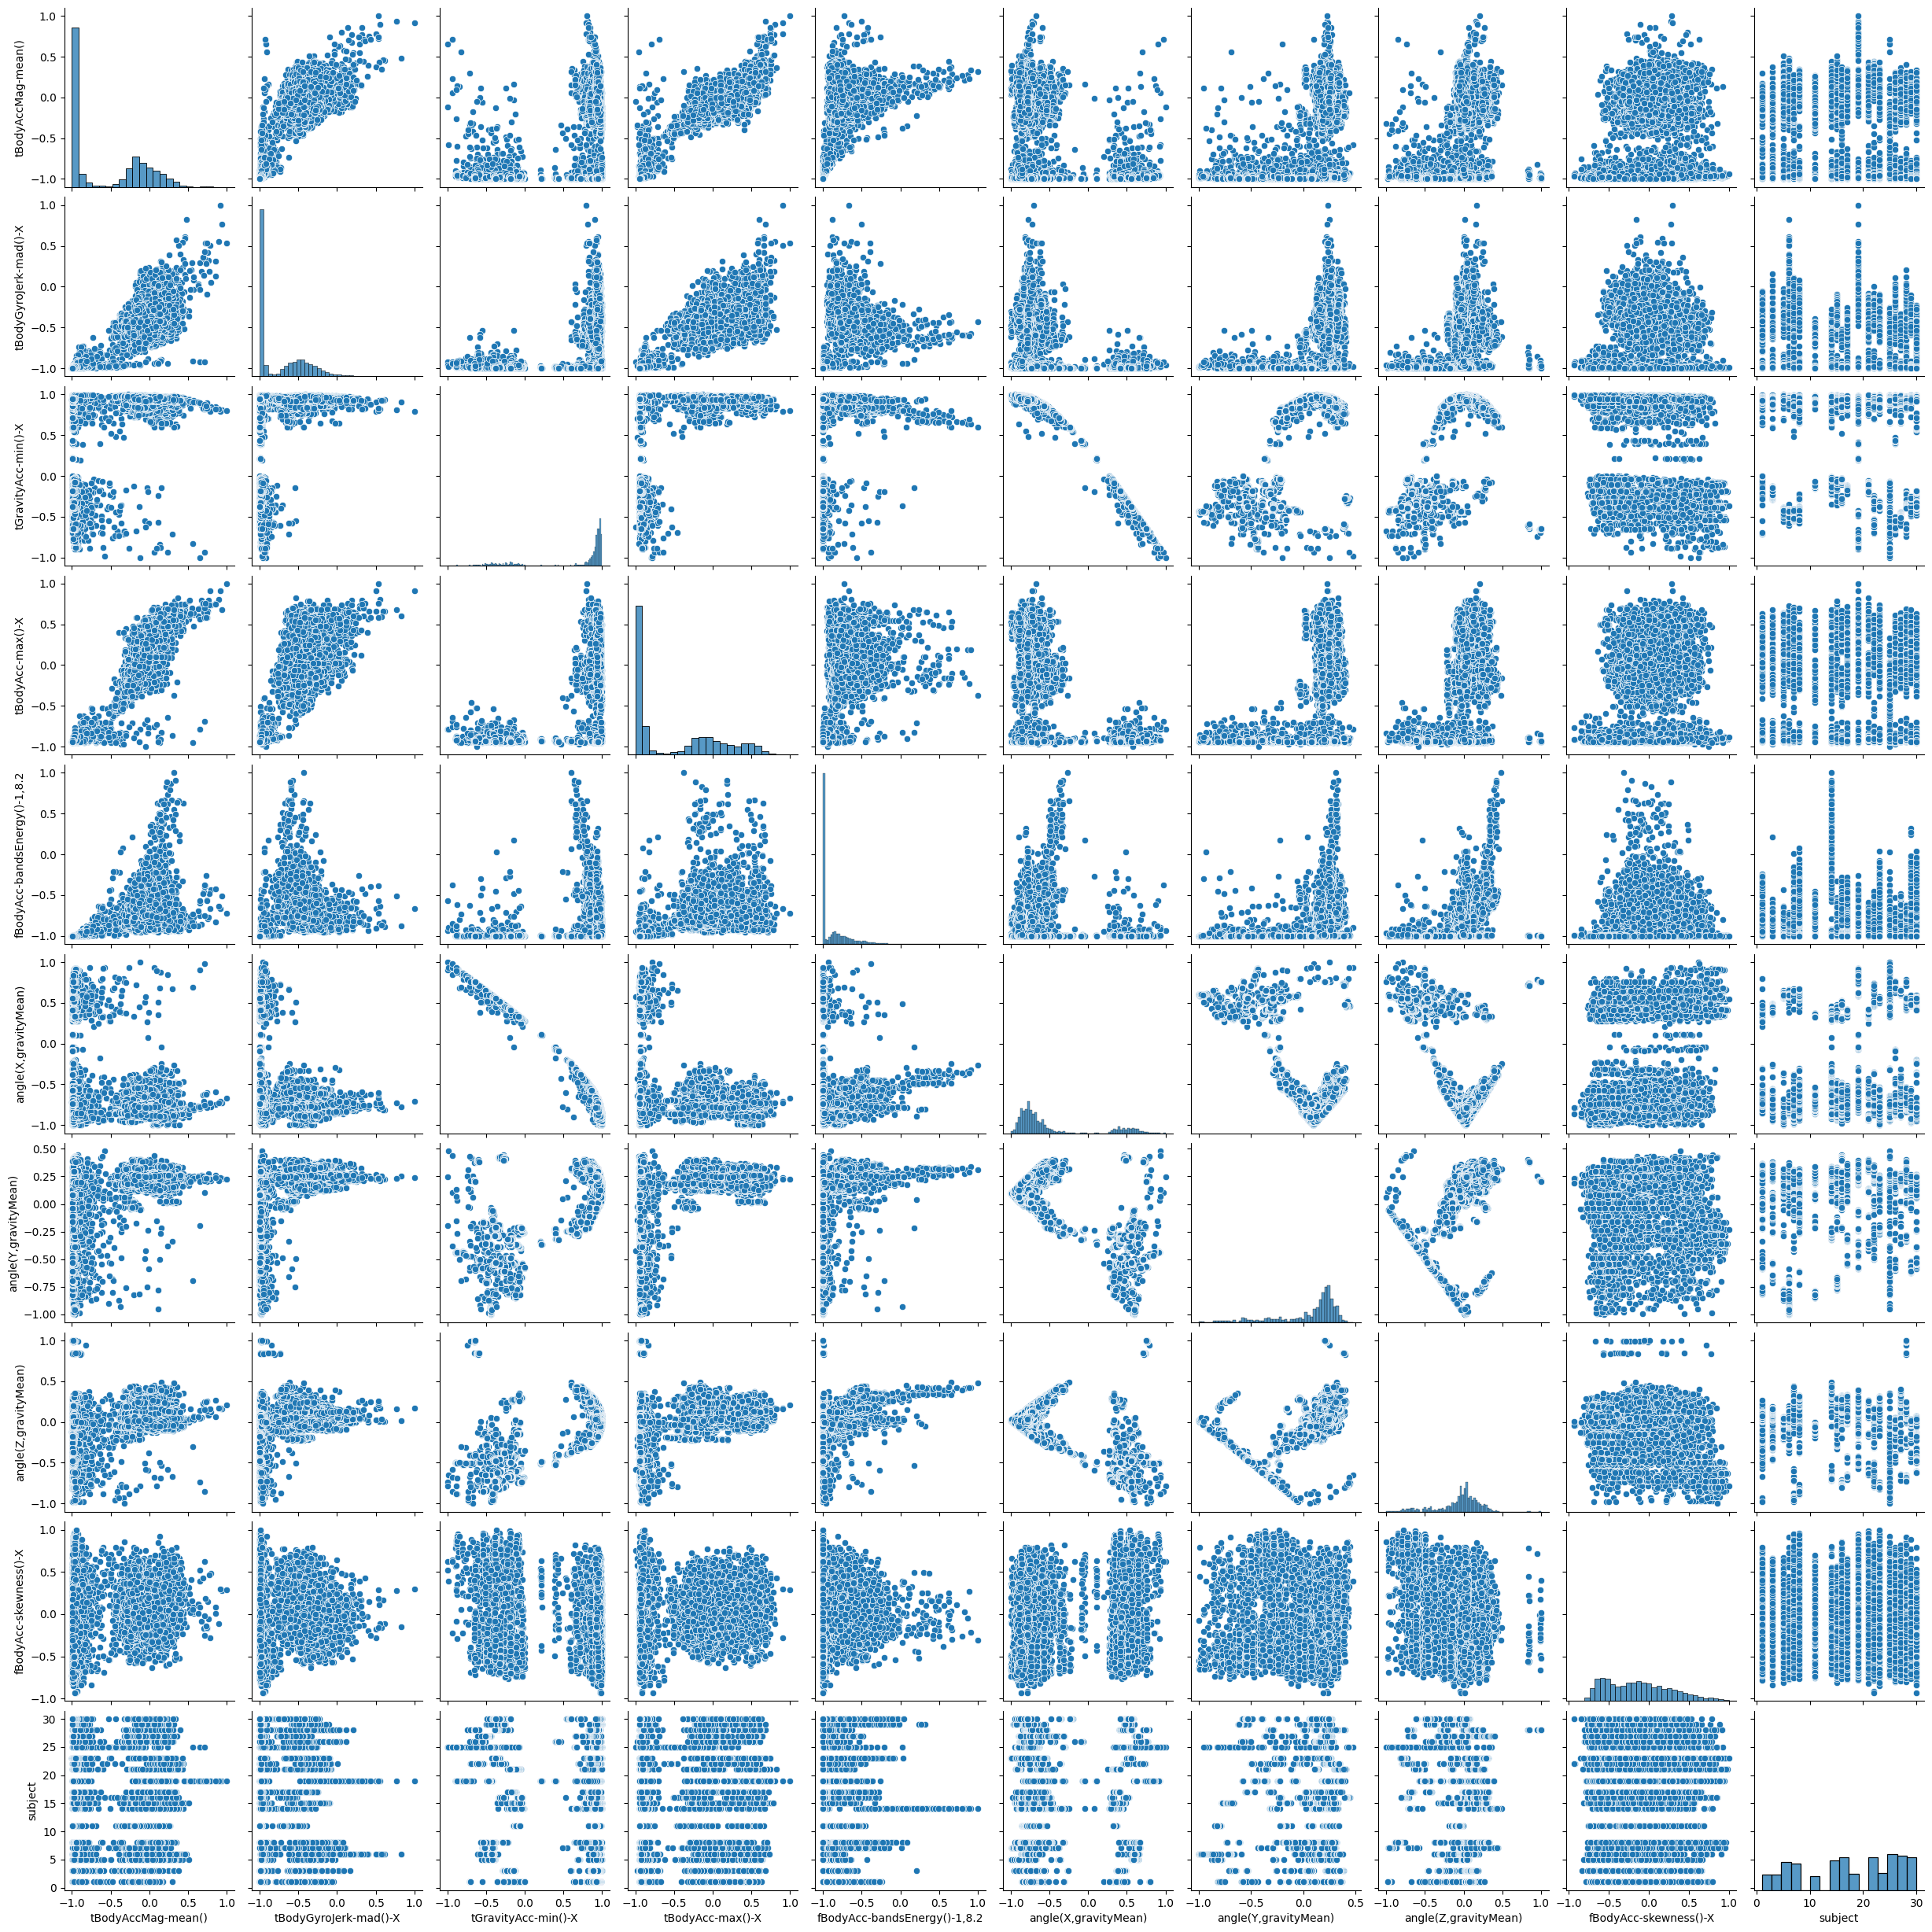

In [ ]:
sns.pairplot(train.iloc[:, :10])
plt.show()

1. **На главной диагонали** расположены гистограммы для каждого признака. Гистограмма показывает распределение значения признака, позволяя увидеть частоту различных значений и диапазоны значений внутри одного признака.Так можно увидеть, например, что tBodyAccMag-mean(), tBodyGyroJerk-mad()-X, tBodyAcc-max()-X чаще всего принимают значения, близкие к -1. Ранее я эту информацию не наблюдала.
2. **В других ячейках**, не на главной диагонали, расположены диаграммы рассеяния (scatter plots), которые показывают взаимосвязь между парами переменных. Каждая точка на таком графике представляет одно наблюдение в данных с координатами, соответствующими значениям пары переменных. Если проанализировать совместно с heatmap, то можно увидеть, что у признаков с высокой корреляцией график рассеяния выглядет соответствующе: точки выстраиваются преимущественно вдоль одной прямой. И наоборот, признаки с низкой корреляцией имеют диаграмму в виде неструктурированного "облака" точек. Это логично с точки зрения определения линейной корреляции.
3. Меня заинтересовали **диаграммы корреляций угловых признаков**. У них средняя корреляция: от -0.78 до -0.59. И на графике видно уже не только облако точек, но и "галочку". Возьмем корреляцию между angle(X,gravityMean) и angle(Y,gravityMean). При -1 <= angle(Y,gravityMean) <= -0.5 не заметна особая корреляция с углом между осью OX. Но при больших углах меджу осью OY и усредненной гравитационной составляющей ускорения корреляция с angle(X,gravityMean) по графику похожа на выпуклую функцию (параболу). Мы можем сегментировать углы между осью OY: angle(Y,gravityMean) ∈ (-1, -0.5) -- нет корреляции с углом между осью OX, (-0.5, 0.1) -- отрицательная линейная корреляция, (0.1, 0.5) -- положительная линейная корреляция. Это может быть полезно для дальнейшего обучения модели.
4. На диаграммах удобно отслеживать **выбросы**.


Анализировать 100 графиков неудобно. Возможно, будет лучше, если мы выведем только диаграммы высококоррелированных признаков.

### Плотность распределения

Окей. Смотреть на все сразу не очень удобно. Кажется, нужно смотреть на признаки в отдельности и искать в них инсайты.

Попробуем проверить гипотезу. Отобразим плотность распределения (kde) `tBodyAccMag-mean()` для каждой из активностей.

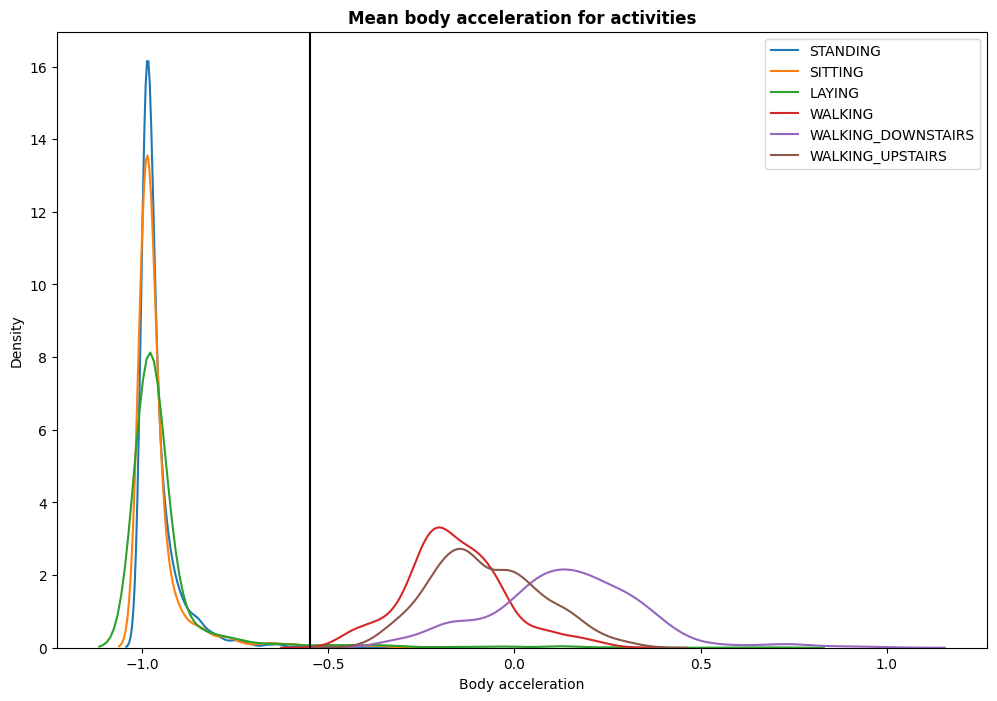

In [ ]:
plt.figure(figsize=(12, 8))

for activity in activities:
  sns.kdeplot(train[train['Activity'] == activity]['tBodyAccMag-mean()'], label=activity)

# Добавим разделение на статические и динамические активности
# Примерный порог для разделения активностей: -0.55
plt.axvline(x=-0.55, color='k', linestyle='-')

'''
Fun fact про color='k': 'k' обозначает черный цвет, потому что 'b' зарезервирована под blue.
Выбор именно буквы 'k' вместо 'b' связан с традицией в типографике и печати,
где 'K' обычно означает "key plate" или "key ink" и относится к черному цвету
в четырехцветной модели печати CMYK (Cyan, Magenta, Yellow, Key/Black).
'''

plt.title('Mean body acceleration for activities', fontweight='bold')
plt.xlabel('Body acceleration')
plt.ylabel('Density')

plt.legend()

plt.show()

In [ ]:
static = ['STANDING', 'SITTING', 'LAYING']

condition1 = (train['tBodyAccMag-mean()'] < -0.55) & train['Activity'].isin(static)
condition2 = (train['tBodyAccMag-mean()'] >= -0.55) & ~train['Activity'].isin(static)

print((train[condition1].shape[0] + train[condition2].shape[0]) / train.shape[0])

0.9908868335146899


In [ ]:
print(train[train['Activity'].isin(static)].shape[0] / train.shape[0])
print(train[train['tBodyAccMag-mean()'] < -0.55].shape[0] / train.shape[0])
print(train[condition1].shape[0] / train.shape[0])

0.5531828073993471
0.544069640914037
0.544069640914037


Доля правильных ответов, которые дает вертикальная линия для разделения активностей на 2 группы (статические и динамические): 0.991.

Признак 'tBodyAccMag-mean()' хорошо разделяет активности на две группы. Дело в том, что при tBodyAccMag-mean() < -0.55 все активности статические. Я доказала это в предыдущем блоке с кодом. Это же можно наблюдать и на графике. Поэтому при tBodyAccMag-mean() < -0.55 доля верных ответов равна 1.

Погрешность возникает из-за того, что в редких случаях при tBodyAccMag-mean() > -0.55 активность является статической (практически всегда активность динамическая). Из графика видно, как "далеко тянется" LAYING.

**Вывод**: метод хороший и дает небольшую погрешность. Не исключено, что погрешность возникает по причине выбросов.

### "Ящики с усами"

Мы проверили первую гипотезу в процессе EDA. Однако нам бы хотелось уметь не группы разделять, а каждый отдельный вид активности. Попробуем нарисовать "ящики с усами" для `angle(X,gravityMean)` с разделением по разным видам активности на данных train.

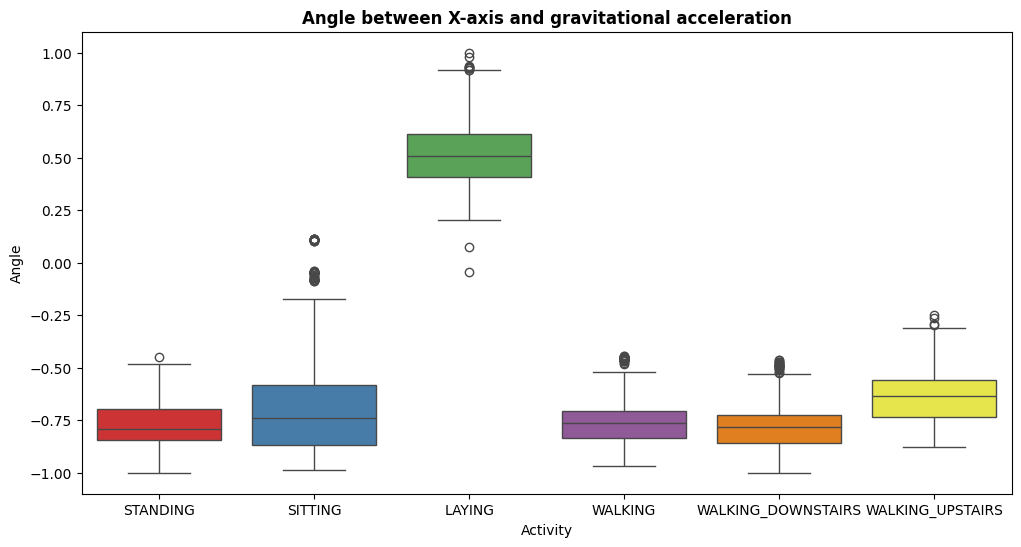

In [ ]:
plt.figure(figsize=(12, 6))

# Создадим boxplot, раскрасим ящики в разные цвета с помощью параметра palette
sns.boxplot(x='Activity', y='angle(X,gravityMean)', data=train, palette='Set1')

plt.xlabel('Activity')
plt.ylabel('Angle')
plt.title('Angle between X-axis and gravitational acceleration', fontweight='bold')

plt.show()

**Нижняя и верхняя границы ящика** представляют первый и третий квантили, то есть границы межквартильного размаха. Этот размах содержит центральные 50% данных. У SITTING половина данных "растянуты" сильнее, чем у остальных активностей. Это говорит о большем стандартном отклонении относительно признака angle(X,gravityMean) у данной активности. Это может быть связано с тем, что положения сидения могут сильно варьироваться между разными людьми и условиями сидения.

**"Усы"** — это линии, которые тянутся от ящика к самым нижним и самым верхним значениям данных, исключая выбросы. Длинные усы у SITTING также подверждают разброс данных.

**Точки за пределами "усов"** считаются выбросами. Наличие выбросов, особенно для активностей STANDING и SITTING, может указывать на индивидуальные особенности положения тела участников или на аномальные данные.

**Значительно выделяется LAYING**. Серединная линия в ящике обозначает медиану данных. Медиана для LAYING значительно отличается от других статических активностей. Это связано с тем, что при лежании тело находится в горизонтальной позиции, что максимально изменяет угол между осью X и направлением гравитационного ускорения, о чем я уже говорила выше.

### Скрипичные диаграммы

Посмотрим теперь на `tBodyAcc-max()-X`. Визуализируем скрипичные диаграммы для этого признака с разделением по активностям на всем train. Кажется логичным, что максимальное ускорение в моменте для разных активностей будет различаться. Однако есть ли активность, которая будет выделяться?

In [ ]:
!pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [ ]:
!pip show seaborn

Name: seaborn
Version: 0.13.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, pandas
Required-by: missingno


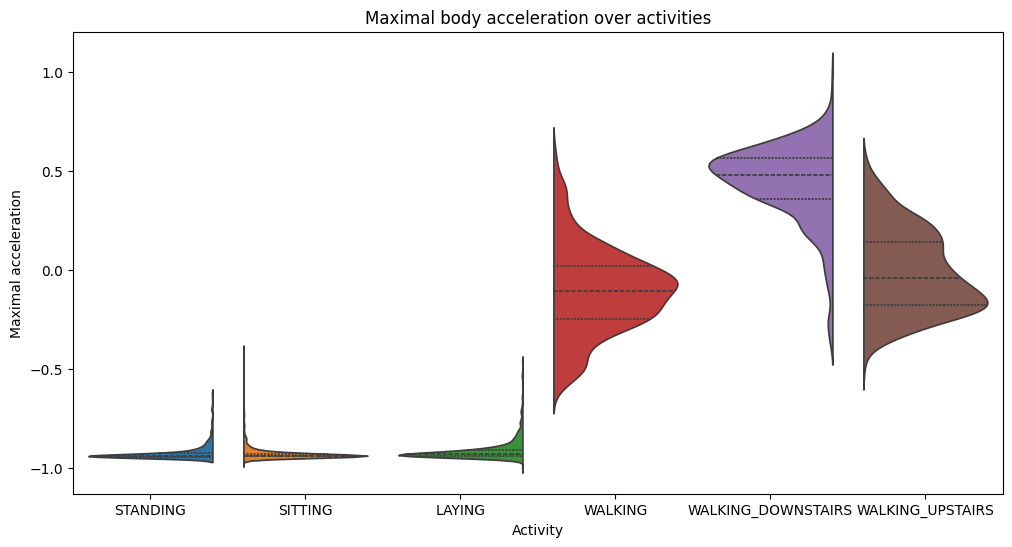

In [ ]:
plt.figure(figsize=(12, 6))

# Создадим скрипичную диаграмму
sns.violinplot(x='Activity', y='tBodyAcc-max()-X', data=train, split=True, inner="quartile", hue="Activity")

plt.xlabel('Activity')
plt.ylabel('Maximal acceleration')
plt.title('Maximal body acceleration over activities')

plt.show()

Скрипичная диаграмма (violin plot) сочетает в себе элементы "ящика с усами" и плотности распределения значений переменной.

Тело скрипичной диаграммы показывает плотность распределения данных: чем шире тело, тем больше наблюдений в данной области. На графике видно, что динамические активности имеют более широкое ("растянутое") распределение, что отражает большую вариативность ускорения при этих динамических активностях. Здесь стоит отметить явное разделение на статические и динамические активности.

**Значительно выделяется активность WALKING_DOWNSTAIRS** с самой большой медианой (примерно 0.5). Я уже говорила ранее о том, что ось X у устройства расположена перпендикулярно земле. Сейчас мы можем сделать вывод, что ось направлена в сторону земли. Потому что именно во время спуска человека происходит ускорение по оси X.

### Разделение датасета train

Мы уже можем с довольно хорошим качеством выделить две категории активности из шести. Продолжим.

Ранее уже упоминалось разделение на две группы активностей: статические и динамические. Пришла пора разделить датасет train на две части. Далее на одной картинке покажем распределения `fBodyAcc-bandsEnergy()-1,8.2` для динамичных активностей (boxenplot - немного измененый "ящик с усами") и `angle(Y,gravityMean)` для статических - тут хватит и простой гистограммы.

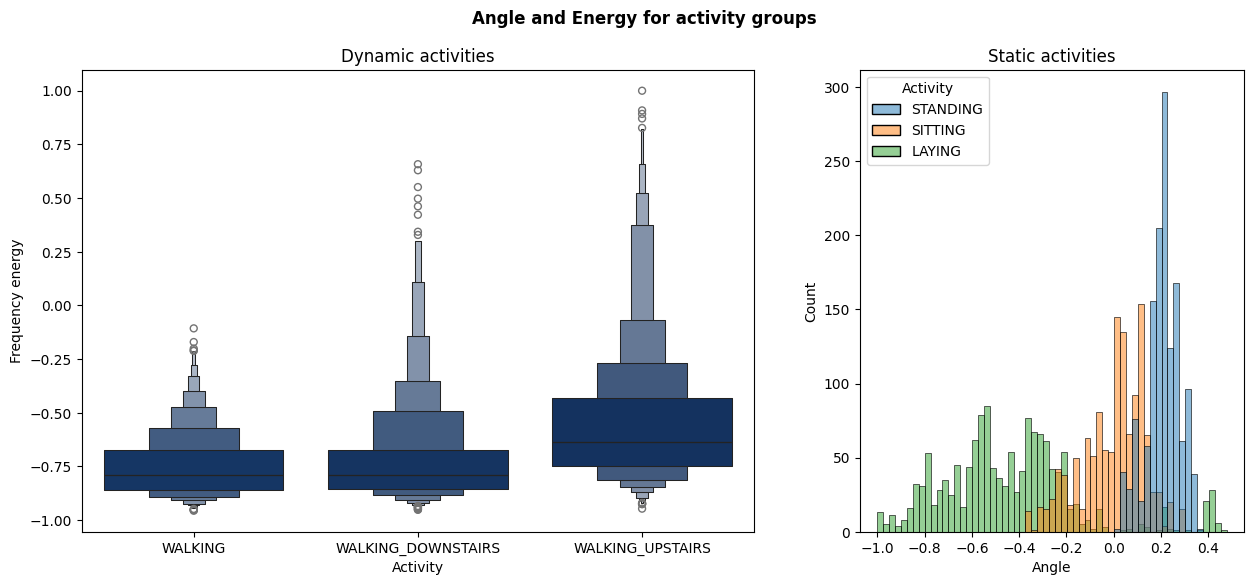

In [ ]:
static_data = train[train['Activity'].isin(static)]
dynamic_data = train[~train['Activity'].isin(static)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1.75, 1]})

# Создадим палитру, где каждой активности соответствует оттенок синего,
# с помощью словаря, где ключами являются уникальные значения активностей,
# а значениями — оттенки синего цвета из палитры Seaborn.
activity_palette = {activity: color for activity, color in
                    zip(dynamic_data['Activity'], sns.color_palette("Blues", len(dynamic_data)))}

# Boxenplot для динамических активностей
sns.boxenplot(ax=ax1, x='Activity', y='fBodyAcc-bandsEnergy()-1,8.2',
              data=dynamic_data, palette=activity_palette)

ax1.set_title('Dynamic activities')
ax1.set_ylabel('Frequency energy')
ax1.set_xlabel('Activity')

# Histplot для статических активностей
sns.histplot(ax=ax2, data=static_data, x='angle(Y,gravityMean)', hue='Activity',
             binwidth=0.025)

ax2.set_title('Static activities')
ax2.set_ylabel('Count')
ax2.set_xlabel('Angle')

plt.suptitle('Angle and Energy for activity groups', fontweight='bold')
plt.show()


**Проанализировав гистограмму**, можно сделать вывод о том, что по углу можно с некоторой точностью определять, какой именно статической активностью занят человек.
*   Если угол не превышает -0.4, значит человек лежит.
*   Если угол находится в диапазоне (-0.2, 0), то человек с большей (но не абсолютной) вероятностью сидит.
*   Если угол находится в диапазоне (0.15, 0.35), то человек с большей (но не абсолютной) вероятностью стоит.
*   Если угол больше 0.35, то высока вероятность того, что человек лежит.
*   В промежуточных значениях, таких как (-0.4, -0.2), (0, 0.15) мы можем предположить, что человек занимается одним из двух соотвествующих видов активностей. Возиожно, здесь мы фиксируем переход из одного положения в другое. Нужно смотреть на другие признаки в совокупности.

**Значительно выделяется STANDING**. Небольшой положительный угол по оси Y говорит о том, что человек стоит и немного наклонен вперед. Действительно, это часто встречающаяся поза, особенно в современном мире, когда многие наклоняются для пользования мобильным гаджетом.

Проанализировав boxenplot, можно сделать вывод о том, что **значительно выделяется WALKING_UPSTAIRS**: если средняя энергия (fBodyAcc-bandsEnergy()-1,8.2) больше -0.65, то с большей вероятностью человек совершает подъем вверх. Я предполагаю, что это связано с тем, что для подъема вверх требуется больше энергии, чем для спуска или прогулки по равнине.





  

### Статические активности

Не всегда жизнь будет такой легкой, а данные будут полностью или почти линейно разделимы в одному признаку (иначе чем бы занимались дата саентисты...). Часто данные вообще ни по одному признаку нельзя адекватно разделить (да и по комбинациям признаков тоже). Давайте попробуем взять не один признак, а целых два!

Рассмотрим только статические активности. Будет снова два графика сразу. На первом графике будет боксплот распределения `fBodyAcc-skewness()-X` по активностям. А на втором попробуем взять не все наблюдения данной группы активностей, а только их часть.

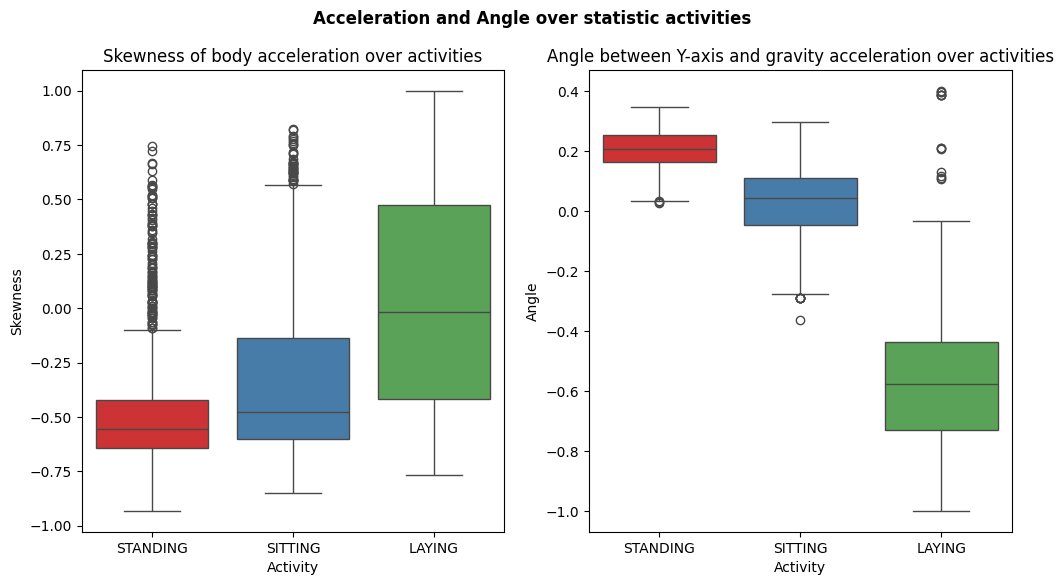

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(ax=ax1, x='Activity', y='fBodyAcc-skewness()-X', data=static_data,
            palette='Set1')

ax1.set_title('Skewness of body acceleration over activities')
ax1.set_ylabel('Skewness')
ax1.set_xlabel('Activity')

filtered_data = static_data[static_data['fBodyAcc-skewness()-X'] < -0.376]
sns.boxplot(ax=ax2, x='Activity', y='angle(Y,gravityMean)', data=filtered_data,
            palette='Set1')

ax2.set_title('Angle between Y-axis and gravity acceleration over activities')
ax2.set_ylabel('Angle')
ax2.set_xlabel('Activity')

plt.suptitle('Acceleration and Angle over statistic activities', fontweight='bold')
plt.show()

Я не могу назвать категорию, которая особенно выделилась на этих графиках. Мы можем сказать, что при fBodyAcc-skewness()-X < -0.376 у LAYING преимущественно отрицательный угол по Y, если не рассматривать выбросы. у STANDING -- положительный (при этом весь межквартильный размах STANDING по первому графику попал на второй график).

**Возможно, стоит рассматривать, что при fBodyAcc-skewness()-X < -0.376, угол по оси Y должен быть близок к нулю, примерно в диапазоне (-0.1, 0.15).**

Теперь мы на шажок ближе к тому, чтобы стать решающим деревом!

### Последняя активность

Вот и осталась лишь одна активность, которую мы никак не выделили. Попробуем и ее какими-то порогами отделить от всех остальных. Да, можно было бы сказать, что, раз уж мы выделили 5 из 6 категорий, то все остальное - это и есть последняя категория, но мы не идем легкими путями. Выделить оставшуюсь категорию с хорошим качеством не так уж и просто. Из доступных признаков, сначала посмотрим на распределение `tBodyAcc-max()-X` на динамических активностях (скрипичная диаграмма отлично подойдет).

А теперь спускаем порог `tBodyAcc-max()-X < 0.157`. Для таких строк построем диаграмму рассеяния для признака `tGravityAcc-min()-X`. Да, получается неидеально, но это честная работа.

Обратим внимание, что подписи к осям можно убирать методами plt. Например, если у нас общее название для оси Y для обоих графиков, то можно не подписывать ось Y у второго графика.

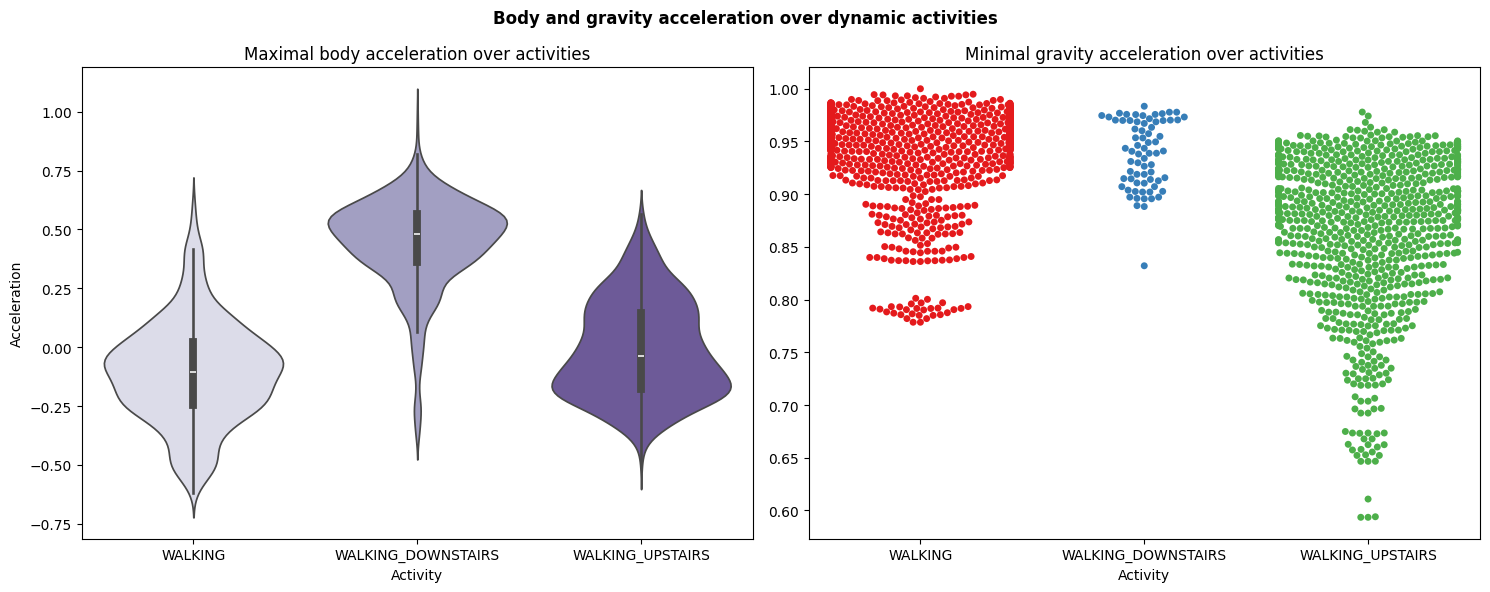

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.violinplot(ax=ax1, x='Activity', y='tBodyAcc-max()-X', data=dynamic_data,
               palette='Purples')

ax1.set_title('Maximal body acceleration over activities')
ax1.set_ylabel('Acceleration')
ax1.set_xlabel('Activity')

filtered_data = dynamic_data[dynamic_data['tBodyAcc-max()-X'] < 0.157]
sns.swarmplot(ax=ax2, x='Activity', y='tGravityAcc-min()-X', data=filtered_data,
              palette='Set1')

ax2.set_title('Minimal gravity acceleration over activities')
ax2.set_ylabel('')
ax1.set_xlabel('Activity')

plt.suptitle('Body and gravity acceleration over dynamic activities',
             fontweight='bold')

plt.tight_layout()
plt.show()

**Здесь выделяется WALKING**. Можно сказать, что при tBodyAcc-max()-X < 0.157 и tGravityAcc-min()-X > 0.9 человек выполняет активность WALKING.

### TSNE

Теперь попробуем более интерактивные графики. Установим библиотеку `plotly`. Синтаксис очень похож на `seaborn`, но вот [документация для plotly.express](https://plotly.com/python-api-reference/plotly.express.html).

Сначала подготовим данные для визуализации. Будем считать t-SNE просто "черным ящиком", который принимает наши данные и проецирует их в двумерное или трехмерное пространство.

In [ ]:
!pip install plotly

In [ ]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(random_state=666, n_components=2)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_2_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y']),
    train['Activity']
], axis=1)

tsne = TSNE(random_state=666, n_components=3)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_3_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y', 'z']),
    train['Activity']
], axis=1)

Теперь нарисуем scatter-график через `plotly.express` для `df_2_comp` с выделением цветами активностей.

In [ ]:
import plotly.express as px

fig = px.scatter(df_2_comp, x='x', y='y', color='Activity',
                 title='t-SNE проекция активностей на 2D пространство',
                 labels={'x': 'Компонент 1', 'y': 'Компонент 2'},
                 color_discrete_sequence=px.colors.qualitative.Plotly)

# Улучшим внешний вид
fig.update_traces(marker=dict(size=5),
                  selector=dict(mode='markers'))

fig.show()

Видны скопления точек. Хорошо можно отделить LAYING, чуть хуже разделены и другие статические активности. Сложнее (но возможно) разделить динамические активности.

Мы не отстаем от трендов и тоже можем в 3D. Нарисуем scatter_3d-график через `plotly.express` для `df_3_comp` с выделением цветами активностей.

In [ ]:
fig = px.scatter_3d(df_3_comp, x='x', y='y', z='z', color='Activity',
                    title='t-SNE проекция активностей на 3D пространство',
                    labels={'x': 'Компонент 1', 'y': 'Компонент 2', 'z': 'Компонент 3'},
                    color_discrete_sequence=px.colors.qualitative.Plotly)

# Улучшим внешний вид
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))

fig.show()

У точек есть структура, и тут так же видно, что LAYING отделяется лучше остальных активностей.

### predict

Мы сделали вам fit. Теперь время сделать predict. Напишем функцию, которая принимает на вход датафрейм с признаками, а выдает вектор из предсказаний - для каждой строки датафрейма мы определяем, к какому классу принадлежит объект. Дальше фукнция `accuracy_score` выдаст нам долю правильных ответов.

Мы уже отделили категории друг от друга по каким-то признакам. Воспользуемся этим знанием!

In [ ]:
def predict(df: pd.DataFrame):
    predictions = []
    for index, row in df.iterrows():
        if row['tBodyAccMag-mean()'] < -0.55: # Статическая активность
            if row['angle(X,gravityMean)'] >= 0.2:
              predictions.append('LAYING')
            elif 0.18 <= row['angle(Y,gravityMean)'] <= 0.35:
              predictions.append('STANDING')
            elif (row['fBodyAcc-skewness()-X'] < -0.376 and
              -0.1 <= row['angle(Y,gravityMean)'] <= 0.1):
              predictions.append('SITTING')
            elif (row['fBodyAcc-skewness()-X'] < -0.376 and
              0.1 <= row['angle(Y,gravityMean)']):
              predictions.append('STANDING')
            else: predictions.append('SITTING')
            '''
            Мы отслеживаем SITTING только при 'fBodyAcc-skewness()-X' < -0.376.
            Если это условие не выполняется, то можно предположить, что другие
            активности уже были выделены по другим признаком и, вероятно,
            мы имеем дело с SITTING, поэтому в итоговом else такой предикт
            '''
        else:                                 # Динамическая активность

            # Некоторые наблюдения с активностью LAYING заходят правее вертикальной черты.
            # Так как LAYING легко отследить по углу по оси X, добавим такое условие.
            if row['angle(X,gravityMean)'] >= 0.2:
              predictions.append('LAYING')
            elif row['tBodyAcc-max()-X'] >= 0.35:
              predictions.append('WALKING_DOWNSTAIRS')
            elif row['fBodyAcc-bandsEnergy()-1,8.2'] > -0.65:
              predictions.append('WALKING_UPSTAIRS')
            elif row['tBodyAcc-max()-X'] < 0.157 and row['tGravityAcc-min()-X'] >= 0.92:
              predictions.append('WALKING')
            elif row['tBodyAcc-max()-X'] < 0.157:
              predictions.append('WALKING_UPSTAIRS')
            elif row['tBodyAcc-max()-X'] >= 0.35:
              predictions.append('WALKING_DOWNSTAIRS')
            elif row['angle(X,gravityMean)'] >= -0.85:
              predictions.append('WALKING_UPSTAIRS')
            else: predictions.append('WALKING')
            # Аналогично с SITTING

    return predictions

def accuracy_score(y_true, y_pred) -> float:
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    return (y_true == y_pred).mean()

In [ ]:
train_preds = predict(train)
test_preds = predict(test)
print(f"Accuracy on train set => {accuracy_score(train['Activity'], train_preds)}")
print(f"Accuracy on test set => {accuracy_score(test['Activity'], test_preds)}")

Accuracy on train set => 0.8260337323177367
Accuracy on test set => 0.7512724804886325


Мы видим переобучение, потому что результат на train значительно выше результата на test. Тем не менее результат весьма хорош.